This notebook aim to evaluate the performances of a given model on an annotated dataset of bee wings. If you want to evaluate a model on the dataset which include your train data. ensure to keep the same random seed when spliting your dataset

In [1]:
#importing libraries and code


import re
import cv2
import matplotlib.pyplot as plt
import os
import matplotlib.colors as mcolors
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
from skimage.morphology import local_maxima
import cv2
import gc
import time
import json


from UNet_class_and_functions import* #this is not a library, but the python code storing UNet class and other useful functions

In [2]:
#loading the model

model_name = "UNet_150_epoch_lr=0.001_seed=58_func=pow_param=30"
model_directory = "/home/gabriel/Documents/TR DIMA/data_clean/models"

model_load = torch.load(model_directory + '/'  + model_name + '.pth',weights_only = False)
model_load.to('cuda') #remove this if you are not using cuda
model_load.eval()  # model to evaluation mode

UNet(
  (encoder1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (encoder2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (encoder3): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(32, 64, kernel_

In [3]:
blacklist = [590,1488] #those 2 wing images had issues and are not well (eg pb with annotation, orientation)
#we'd like to test the newly trained model with augmented images on not augmented images. we should thus load theses non augmented images and pass it through the model
#Loading data without data augmentation (run this cell if you don't want it)

#Loading data an prepare it for training
from torchvision import transforms

# Define the transformation
transform_input = transforms.Compose([
    transforms.ToTensor()
])

transform_annotation = transforms.Compose([
    transforms.ToTensor()
])

new_dataset_directory = "/home/gabriel/Documents/TR DIMA/data/UMons_preprocessed_images_v2"
new_annotations_directory = "/home/gabriel/Documents/TR DIMA/data/UMons_preprocessed_images_annotations_v2"

image_name_list = list_directory_contents(new_dataset_directory)

blacklist_index = []
#identifying index of blacklisted data
for index,name in enumerate(image_name_list):        
        match = re.search(r'_(\d+)\.png', name) # Regular expression to extract the number

        number = int(match.group(1))
        if number in blacklist:
             blacklist_index.append(index)

print(blacklist_index)

#we then have to split the dataset the way it was done (we can do this thanks to random seed that has been set before)
random_seed = RANDOM_SEED

# Split the dataset
train_set_index, test_set_index = train_test_split(np.array([i for i in range(len(image_name_list))]), test_size=0.2, random_state=random_seed)
val_set_index, test_set_index = train_test_split(test_set_index, test_size=0.5, random_state=random_seed)


train_set_index = np.array([index for index in train_set_index if not index in blacklist_index])
val_set_index = np.array([index for index in val_set_index if not index in blacklist_index])
test_set_index = np.array([index for index in test_set_index if not index in blacklist_index])




images_input_noaug = [] #3 channels images. the dataset is not so big, so we can stack it on a list, event if it's flash memory consuming
images_output_noaug = [] #1 channel image
original_annotations_list = [] #original annotations (stored in np arrays)

for index,name in enumerate(image_name_list):        
        match = re.search(r'_(\d+)\.png', name) # Regular expression to extract the number

        number = int(match.group(1))


        image = cv2.imread(new_dataset_directory+'/'+f'UMons_preprocessed_image_v2_{number}.png')   
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        image_rgb = transform_input(image_rgb)
        images_input_noaug.append(image_rgb)

        relief_functions_test = dict(zip([i for i in range(18)],[np.power]*18))

        parameters_test = { i : [30] for i in range(18)}

        radius = [60*np.sqrt(2) for i in range(18)]



        original_annotations = np.load(new_annotations_directory+'/'+f"UMons_preprocessed_data_annotations_v2_{number}.npy")

        original_annotations_list.append(original_annotations)

        original_annotations_copy = np.copy(original_annotations[:,::-1])

        original_annotations_copy = np.array(original_annotations_copy,dtype = np.int64)

        image_annotation = creation_relief_ulti_v2(original_annotations_copy,radius,relief_functions_test,parameters_test) #this step in only necessary for the computation of the validation loss

        images_output_noaug.append(image_annotation)










train_set_noaug = np.array(images_input_noaug)[train_set_index]
train_outputs_noaug = np.array(images_output_noaug)[train_set_index]

val_set_noaug = np.array(images_input_noaug)[val_set_index]
val_outputs_noaug = np.array(images_output_noaug)[val_set_index]

test_set_noaug = np.array(images_input_noaug)[test_set_index]
test_outputs_noaug = np.array(images_output_noaug)[test_set_index]

#creating test and train dataset and dataloader
batch_size = 8

# Convert to tensors
train_set_noaug = torch.Tensor(train_set_noaug)
train_outputs_noaug = torch.Tensor(train_outputs_noaug)
val_set_noaug = torch.Tensor(val_set_noaug)
val_outputs_noaug = torch.Tensor(val_outputs_noaug)
test_set_noaug = torch.Tensor(test_set_noaug)
test_outputs_noaug = torch.Tensor(test_outputs_noaug)

from torch.utils.data import DataLoader, TensorDataset

# Create a TensorDataset
train_dataset_noaug = TensorDataset(train_set_noaug, train_outputs_noaug)
val_dataset_noaug = TensorDataset(val_set_noaug, val_outputs_noaug)
test_dataset_noaug = TensorDataset(test_set_noaug, test_outputs_noaug)

# Create a DataLoader
train_loader_noaug = DataLoader(train_dataset_noaug, batch_size=batch_size, shuffle=True)
val_loader_noaug = DataLoader(val_dataset_noaug, batch_size=batch_size, shuffle=False)
test_loader_noaug = DataLoader(test_dataset_noaug, batch_size=batch_size, shuffle=False)


# computing predictions for test loader, and mean validation loss, in order to evaluate if data augmentation was useful or not.
# wa might need to change some things in the algorithm for points retrieval in order to get better results

count = 0
predicted_annotations_list = []
predicted_annotations_images = []


for images,labels in val_loader_noaug:


    with torch.no_grad():

        outputs = model_load(images.to('cuda'))
        outputs_array = outputs.to('cpu').detach().numpy()#.transpose(1,2,0)

        print(outputs_array.shape)
        for output_array in outputs_array:
            output_array = output_array.transpose(1,2,0)

            points = np.argwhere(local_maxima(output_array) == True)

            point_values = np.zeros(len(points))

            for i,pt in enumerate(points):

                value = output_array[int(pt[0]),int(pt[1])]
                point_values[i] = value

            sorting = np.argsort(point_values)


            sort_points = points[sorting,:]

            final_points = sort_points[-np.min([18,len(point_values)]):,:]

            predicted_annotations_images.append(output_array)

            predicted_annotations_list.append(final_points)

        count +=1

        gc.collect()
        del images
        torch.cuda.empty_cache()



[686, 1329]
(8, 1, 256, 512)


/tmp/ipykernel_13238/4025702410.py:153: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  point_values[i] = value


(8, 1, 256, 512)
(8, 1, 256, 512)
(8, 1, 256, 512)
(8, 1, 256, 512)
(8, 1, 256, 512)
(8, 1, 256, 512)
(8, 1, 256, 512)
(8, 1, 256, 512)
(8, 1, 256, 512)
(8, 1, 256, 512)
(8, 1, 256, 512)
(8, 1, 256, 512)
(8, 1, 256, 512)
(8, 1, 256, 512)
(8, 1, 256, 512)
(8, 1, 256, 512)
(8, 1, 256, 512)
(8, 1, 256, 512)
(8, 1, 256, 512)
(8, 1, 256, 512)
(3, 1, 256, 512)


In [4]:
#computing true validation loss
# Compute val loss
model_load.eval()  # Set the model to evaluation mode
running_val_loss = 0.0
criterion = nn.L1Loss()

with torch.no_grad():
    for images, labels in val_loader_noaug:
        labels = torch.unsqueeze(labels,1)
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model_load(images)
        loss = criterion(outputs, labels)
        running_val_loss += loss.item()

# Compute average test loss and accuracy
avg_val_loss = running_val_loss / len(val_loader_noaug)

print(f"True validation loss : {avg_val_loss}")

True validation loss : 0.0012710879514501853


In [5]:
print(avg_val_loss)

0.0012710879514501853


In [6]:
#preparing annotations of val_set

original_annotations_list_t = [original_annotations_list[i][:,::-1] for i in val_set_index] #in order to get only annotations for validation dataset
original_annotations_list_t = np.array(original_annotations_list_t,dtype = np.int64)
index_pb = []
for i,pred in enumerate(predicted_annotations_list):
    #print(pred.shape)
    if pred.shape != (18,3):
        index_pb.append(i)

predicted_annotations_list_clean = [predicted_annotations_list[i] for i in range(len(predicted_annotations_list)) if i not in index_pb]
predicted_annotations_list = np.array(predicted_annotations_list_clean)[:,:,:2]
print("nombre d'ailes problématiques :",len(index_pb))


nombre d'ailes problématiques : 0


In [7]:
#displaying problematic images and annotations

for index in index_pb:
    pb_image = predicted_annotations_images[index]
    plt.imshow(pb_image,cmap = 'plasma')
    plt.show()
    pb_wing = val_set_noaug[index]
    pb_wing = pb_wing.numpy().transpose(1,2,0)
    plt.imshow(pb_wing[:,:,:])
    
    ann  = original_annotations_list_t[index]
    plt.plot(ann[:,1],ann[:,0],'ro')
    plt.show()

In [8]:
#some useful functions for the cells below


def from_array_to_tuple_3D(array):
    """this function convert an array into a list of tuple of it's values. We assume it's a 3D array"""
    return [[tuple(a) for a in b] for b in array]

def from_array_to_tuple_2D(array):
    return [tuple(a) for a in array]

def from_tuple_to_array_2D(tuple_list):
    return np.array([[a for a in b]for b in tuple_list])

def closest_neighboor(points,neighboors):
    """this function take a list of points to assignate, and a list a points to be associated with (neighboors). for each point, from points
    It will find the closest point in neighboors. It finally return a list with a list of len len(neighboors), with in index i a list with closest points for neighboor i
    """

    list_neighboors = [[] for i in range(len(neighboors))]
    for point in points:
        min_distance = np.inf
        min_neighboor = 0
        for index,nei in enumerate(neighboors):
            current_distance = np.linalg.norm(point-nei)
            if current_distance < min_distance:
                min_distance = current_distance
                min_neighboor = index
        list_neighboors[min_neighboor].append(point)
    return list_neighboors

def point_assignation(closest_neighboors,neighboors,final_assignation = [None]*18):


    
    for i,assign in enumerate(closest_neighboors):
        if len(assign) == 1:
            final_assignation[i] = assign[0]
            closest_neighboors[i].pop(0)
        if len(assign) > 1:
            min_dist = np.inf
            min_pt = assign[0]
            min_index = 0
            for j,pt in enumerate(assign):
                current_dist = np.linalg.norm(pt-neighboors[i])
                if current_dist < min_dist:
                    min_dist = current_dist
                    min_pt = pt
                    min_index = j
            final_assignation[i] = min_pt
            closest_neighboors[i].pop(min_index)
    unassignated = [index for index in range(len(final_assignation)) if type(final_assignation[index]) == type(None)]

    return final_assignation
        
def point_assignation_v2(predicted_annotations : list, annotations : list, current_pairs = None) -> list:
    """this function return a list with pairs predicted, annotated correctly put together"""
    predicted_annotations_copy = from_array_to_tuple_2D(predicted_annotations).copy()
    annotations_copy = from_array_to_tuple_2D(annotations).copy()
    if type(current_pairs) == type(None):
        current_pairs_ini = [] #we initialise the list
    else :
        current_pairs_ini = current_pairs.copy()
    if len(predicted_annotations) <= 0:
        return current_pairs_ini
    closest_neighboors = from_array_to_tuple_3D(closest_neighboor(from_tuple_to_array_2D(predicted_annotations_copy),from_tuple_to_array_2D(annotations_copy)))
    for index,neis in enumerate(closest_neighboors[::-1]):
        if len(neis) == 1:
            current_pairs_ini.append((annotations_copy[len(closest_neighboors)-index-1],neis[0]))
            predicted_annotations_copy.pop(predicted_annotations_copy.index(neis[0]))
            annotations_copy.pop(len(closest_neighboors)-index-1)
        elif len(neis) > 1:
            min_dist = np.inf
            min_pt = neis[0]
            for pt in neis:
                dist = np.linalg.norm(np.array(pt)-np.array(annotations_copy[len(closest_neighboors)-index-1]))
                if dist < min_dist:
                    min_dist = dist
                    min_pt = pt
            current_pairs_ini.append((annotations_copy[len(closest_neighboors)-index-1],min_pt))
            predicted_annotations_copy.pop(predicted_annotations_copy.index(pt))
            annotations_copy.pop(len(closest_neighboors)-index-1)

    return point_assignation_v2(predicted_annotations_copy,annotations_copy,current_pairs=current_pairs_ini)

def calculate_biais(positions_count : dict) -> tuple:

    positions = list(positions_count.keys())
    populations = np.array(list(positions_count.values()))
    positions_array  = from_tuple_to_array_2D(positions)
    biais = np.sum(positions_array*np.expand_dims(populations,axis = 1),axis = 0)/np.sum(populations)
    return biais

def calculate_mean_error(positions_count : dict) -> np.float64:
        positions = list(positions_count.keys())
        populations = np.array(list(positions_count.values()))
        positions_array  = from_tuple_to_array_2D(positions)
        mean_error = np.sum(np.linalg.norm(positions_array,axis = 1)*populations)/np.sum(populations)
        return mean_error


def treshold_examination(threshold):
    """this function apply all the above calculations without displaying anything to evaluate the role of threshold factor in prediction, to know how to inprove really 
    correctness of prediction or if it's a matter of precision"""
    for index,annotation in enumerate(original_annotations_list_t):
            predicted_annotation = predicted_annotations_list[index]


    final_assignations = []
    for index,annotation in enumerate(original_annotations_list_t):
        predicted_annotation = predicted_annotations_list[index]
        closest_neighboors = closest_neighboor(predicted_annotation,annotation)
        final_assignation = point_assignation_v2(predicted_annotation,annotation)
        final_assignations.append((final_assignation,annotation))

    threshold  = threshold #if the distance to the annotation is higher than this threshold, then we classifie this point as wrongly classified, and don' t consider it for calculus
    count_threshold = 3
    mean_error_list = []
    uncorrect_wings = [] #this will store indexes of wings uncorrectly classified
    misclassification_rate_list = []
    distances_list = []

    for index in range(len(original_annotations_list_t[0])):
        pos_count = {} 
        misclassifications = [] 
        for i,(final,annotate) in enumerate(final_assignations):
            annotate_int = np.int64(annotate) #converting float coordinates to int coordinates
            annotate_tuple = from_array_to_tuple_2D(annotate_int)



            for ann,pred in final:
                ann = tuple(np.int64(np.array(ann))) #converting coordinates to integer the same way as above
                current_index = annotate_tuple.index(ann)
                relative_pos = np.array(pred)-np.array(ann) #this correction is necessary because the creation_relief function don't place the maximax at the right places
                relative_pos = tuple(relative_pos)
                if current_index == index:
                    dist = np.linalg.norm(np.array(ann)-np.array(pred))
                    distances_list.append(dist)
                    if dist <= threshold:
  
                        if relative_pos in pos_count.keys():
                            pos_count[relative_pos] += 1
                        else : pos_count[relative_pos] = 1
                    else :
                        misclassifications.append(relative_pos)
                        uncorrect_wings.append(i)


    
        

        positions = list(pos_count.keys())
        populations = np.array(list(pos_count.values()))
        population_clean = [pop  for pop in populations if pop >= count_threshold ]
        population_clean_index = [i for i in range(len(populations)) if populations[i] >= count_threshold]
        positions_clean = [positions[i] for i in population_clean_index]
        misclassification_rate = len(misclassifications)/len(original_annotations_list_t)

        X = np.array([x for x,y in positions_clean])
        Y = np.array([y for x,y in positions_clean])


        # Setting axis limits symmetrically around zero
        max_limit = max(np.max(np.abs(X)), np.max(np.abs(Y)))
        plt.xlim(-max_limit-2, max_limit+2)
        plt.ylim(-max_limit-2, max_limit+2)

        # Setting integer ticks
        plt.xticks(np.arange(-int(max_limit)-2, int(max_limit) + 2, 1))
        plt.yticks(np.arange(-int(max_limit)-2, int(max_limit) + 2, 1))


        #mean distance
        mean_error = calculate_mean_error(pos_count)
        mean_error_list.append(mean_error)

        misclassification_rate_list.append(misclassification_rate)

    #let's have a look of correcly annotated wings rate
    uncorrect_wings = list(set(uncorrect_wings))

    return np.array(mean_error_list),np.array(misclassification_rate_list),len(uncorrect_wings)/len(final_assignations),distances_list

    #let's display uncorrecly annotated wings with ground truth and predicted annotations, and subplot to each point it's localisation in the wing for better understanding

def from_array_to_tuple_3D(array):
    """this function convert an array into a list of tuple of it's values. We assume it's a 3D array"""
    return [[tuple(a) for a in b] for b in array]

def from_array_to_tuple_2D(array):
    return [tuple(a) for a in array]

def from_tuple_to_array_2D(tuple_list):
    return np.array([[a for a in b]for b in tuple_list])

def closest_neighboor(points,neighboors):
    """this function take a list of points to assignate, and a list a points to be associated with (neighboors). for each point, from points
    It will find the closest point in neighboors. It finally return a list with a list of len len(neighboors), with in index i a list with closest points for neighboor i
    """

    list_neighboors = [[] for i in range(len(neighboors))]
    for point in points:
        min_distance = np.inf
        min_neighboor = 0
        for index,nei in enumerate(neighboors):
            current_distance = np.linalg.norm(point-nei)
            if current_distance < min_distance:
                min_distance = current_distance
                min_neighboor = index
        list_neighboors[min_neighboor].append(point)
    return list_neighboors

def point_assignation(closest_neighboors,neighboors,final_assignation = [None]*18):


    
    for i,assign in enumerate(closest_neighboors):
        if len(assign) == 1:
            final_assignation[i] = assign[0]
            closest_neighboors[i].pop(0)
        if len(assign) > 1:
            min_dist = np.inf
            min_pt = assign[0]
            min_index = 0
            for j,pt in enumerate(assign):
                current_dist = np.linalg.norm(pt-neighboors[i])
                if current_dist < min_dist:
                    min_dist = current_dist
                    min_pt = pt
                    min_index = j
            final_assignation[i] = min_pt
            closest_neighboors[i].pop(min_index)
    unassignated = [index for index in range(len(final_assignation)) if type(final_assignation[index]) == type(None)]

    return final_assignation
        
def point_assignation_v2(predicted_annotations : list, annotations : list, current_pairs = None) -> list:
    """this function return a list with pairs predicted, annotated correctly put together"""
    predicted_annotations_copy = from_array_to_tuple_2D(predicted_annotations).copy()
    annotations_copy = from_array_to_tuple_2D(annotations).copy()
    if type(current_pairs) == type(None):
        current_pairs_ini = [] #we initialise the list
    else :
        current_pairs_ini = current_pairs.copy()
    if len(predicted_annotations) <= 0:
        return current_pairs_ini
    closest_neighboors = from_array_to_tuple_3D(closest_neighboor(from_tuple_to_array_2D(predicted_annotations_copy),from_tuple_to_array_2D(annotations_copy)))
    for index,neis in enumerate(closest_neighboors[::-1]):
        if len(neis) == 1:
            current_pairs_ini.append((annotations_copy[len(closest_neighboors)-index-1],neis[0]))
            predicted_annotations_copy.pop(predicted_annotations_copy.index(neis[0]))
            annotations_copy.pop(len(closest_neighboors)-index-1)
        elif len(neis) > 1:
            min_dist = np.inf
            min_pt = neis[0]
            for pt in neis:
                dist = np.linalg.norm(np.array(pt)-np.array(annotations_copy[len(closest_neighboors)-index-1]))
                if dist < min_dist:
                    min_dist = dist
                    min_pt = pt
            current_pairs_ini.append((annotations_copy[len(closest_neighboors)-index-1],min_pt))
            predicted_annotations_copy.pop(predicted_annotations_copy.index(pt))
            annotations_copy.pop(len(closest_neighboors)-index-1)

    return point_assignation_v2(predicted_annotations_copy,annotations_copy,current_pairs=current_pairs_ini)

def calculate_biais(positions_count : dict) -> tuple:

    positions = list(positions_count.keys())
    populations = np.array(list(positions_count.values()))
    positions_array  = from_tuple_to_array_2D(positions)
    biais = np.sum(positions_array*np.expand_dims(populations,axis = 1),axis = 0)/np.sum(populations)
    return biais

def calculate_mean_error(positions_count : dict) -> np.float64:
        positions = list(positions_count.keys())
        populations = np.array(list(positions_count.values()))
        positions_array  = from_tuple_to_array_2D(positions)
        mean_error = np.sum(np.linalg.norm(positions_array,axis = 1)*populations)/np.sum(populations)
        return mean_error

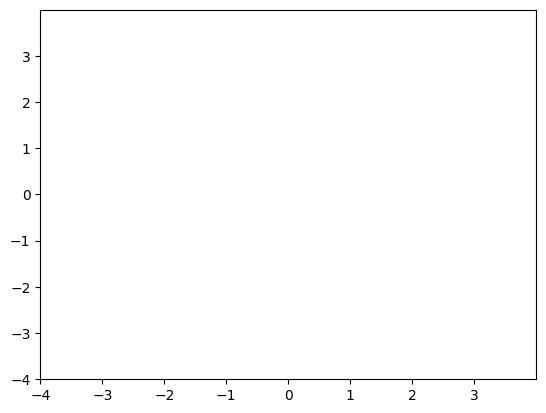

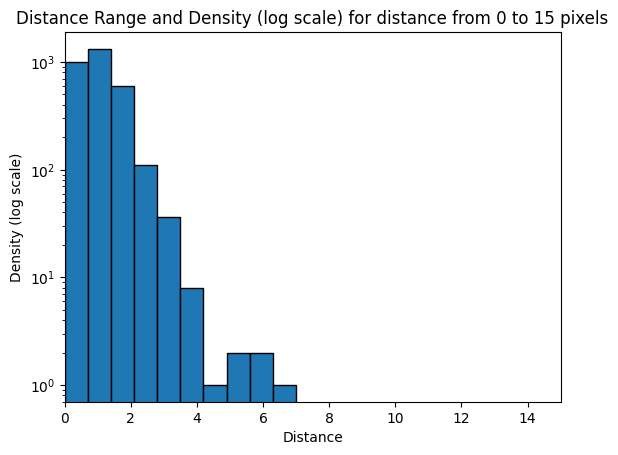

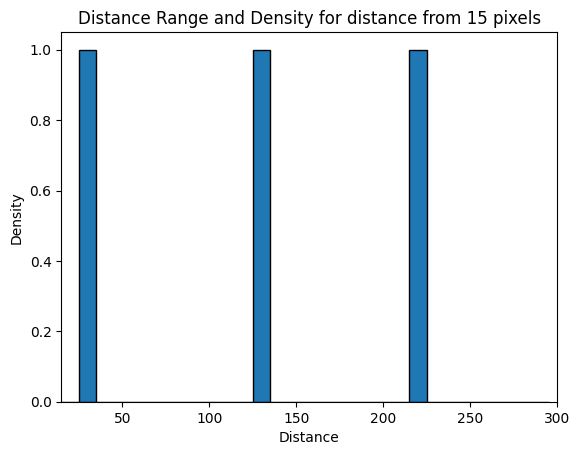

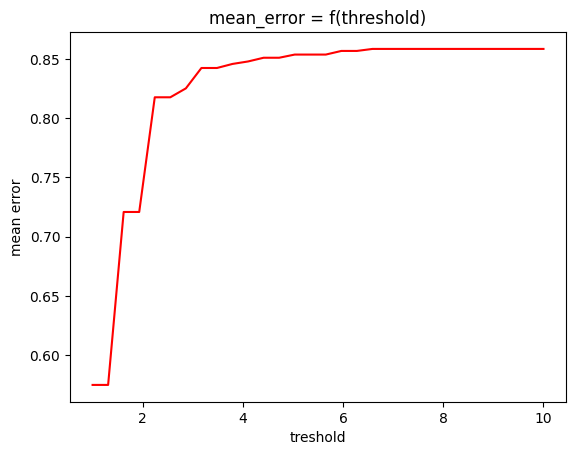

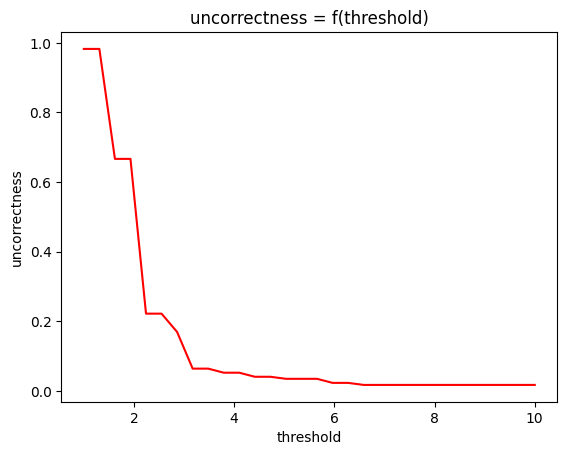

In [9]:
#investigation the distance to the prediction and making plots

plt.clf()
thresholds = np.linspace(1,10,30)
uncorrectness=  []
mean_error_list = []
count = 0
for thresh in thresholds:
    mean_errors,misclassification_rates,uncorrect,distances_list = treshold_examination(thresh)
    mean_error = np.mean(mean_errors)
    mean_error_list.append(mean_error)
    uncorrectness.append(uncorrect)
    count += 1

plt.plot([0])
plt.show()

#cleaning distances list

distances_list = np.array(distances_list)
distance_list_below = distances_list[distances_list < 15]
distance_list_above = distances_list[distances_list > 15]

# Create histogram plot
plt.hist(distance_list_below, bins=np.arange(0,15,0.7), edgecolor='black')
plt.xlim(0,15)

plt.yscale('log')

# Add title and labels
plt.title('Distance Range and Density (log scale) for distance from 0 to 15 pixels')
plt.xlabel('Distance')
plt.ylabel('Density (log scale)')

# Show plot
plt.show()

# Create histogram plot
plt.hist(distance_list_above,bins=range(15,305,10), edgecolor='black')
plt.xlim(15,300)

# Add title and labels
plt.title('Distance Range and Density for distance from 15 pixels')
plt.xlabel('Distance')
plt.ylabel('Density')

# Show plot
plt.show()

plt.plot(thresholds,mean_error_list,'r')
plt.title('mean_error = f(threshold)')
plt.xlabel('treshold')
plt.ylabel('mean error')
plt.show()
plt.plot(thresholds,uncorrectness,'r')
plt.title("uncorrectness = f(threshold)")
plt.xlabel('threshold')
plt.ylabel('uncorrectness')
plt.show()

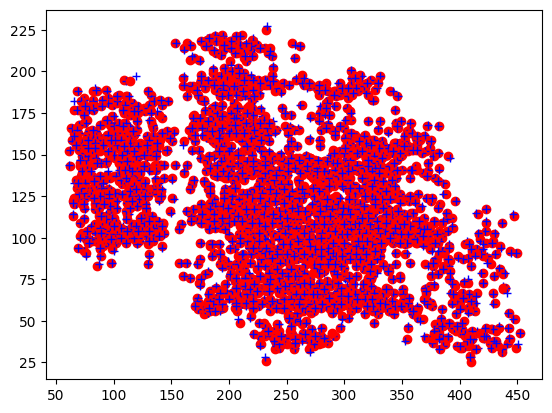

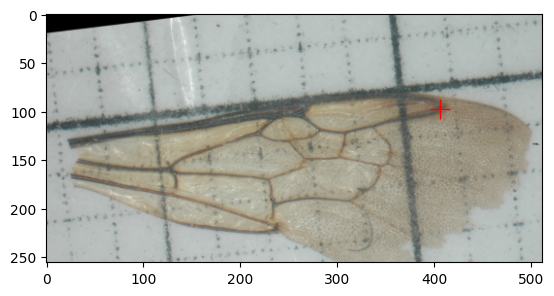

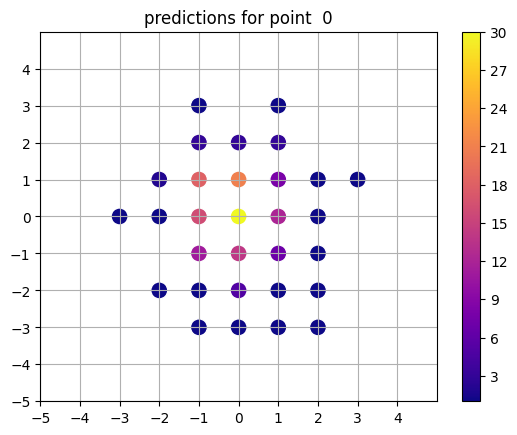

biais for point 0 : [-0.09467456  0.07100592]
mean error for point 0 : 1.2019645343207808
number of misclassified points for point 0 :  2
misclassification rate for point 0 : 0.011695906432748537


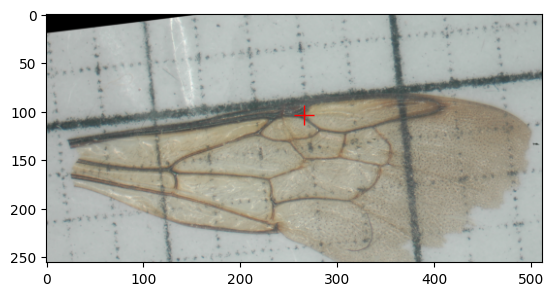

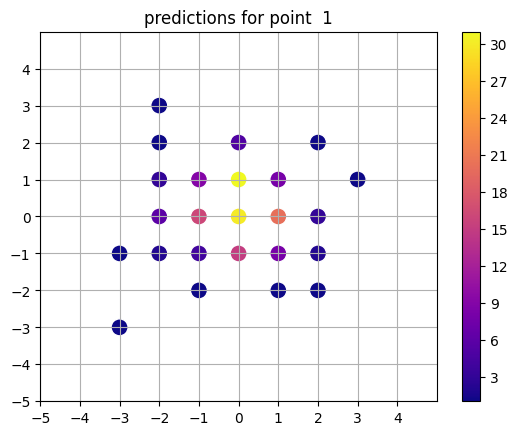

biais for point 1 : [-0.04678363  0.16374269]
mean error for point 1 : 1.133303121423839
number of misclassified points for point 1 :  0
misclassification rate for point 1 : 0.0


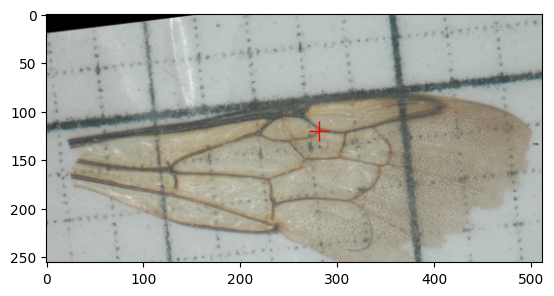

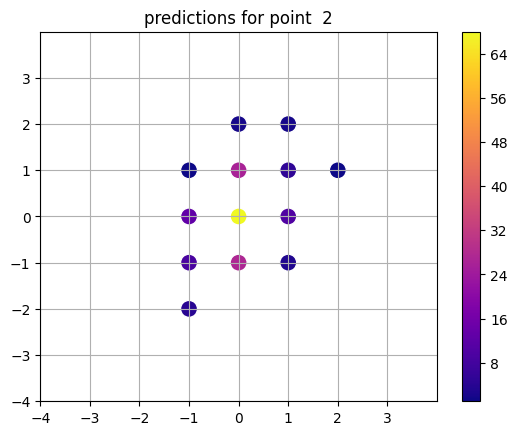

biais for point 2 : [-0.02923977 -0.03508772]
mean error for point 2 : 0.7082357892702588
number of misclassified points for point 2 :  0
misclassification rate for point 2 : 0.0


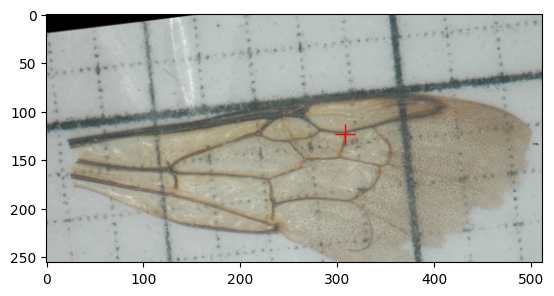

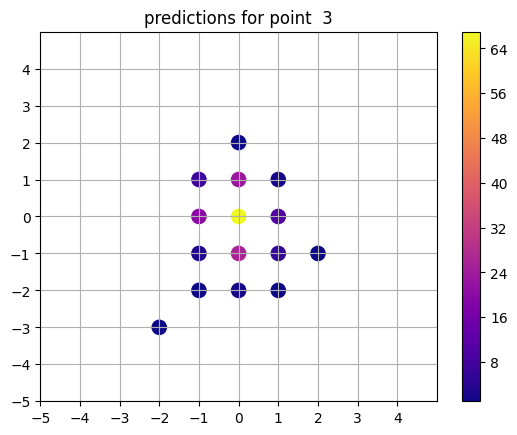

biais for point 3 : [-0.07017544 -0.07602339]
mean error for point 3 : 0.7062549668460765
number of misclassified points for point 3 :  0
misclassification rate for point 3 : 0.0


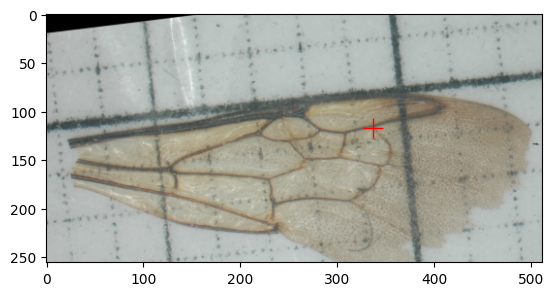

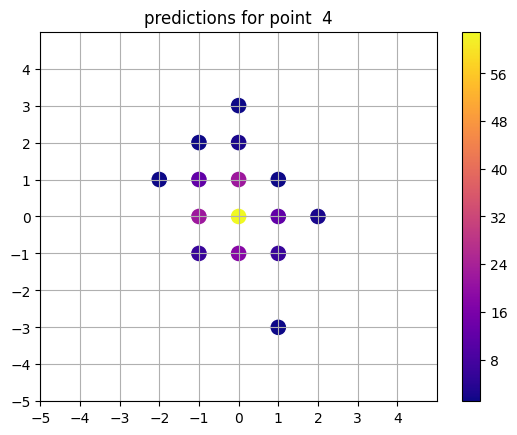

biais for point 4 : [-0.11176471  0.07058824]
mean error for point 4 : 0.7528808980852667
number of misclassified points for point 4 :  1
misclassification rate for point 4 : 0.005847953216374269


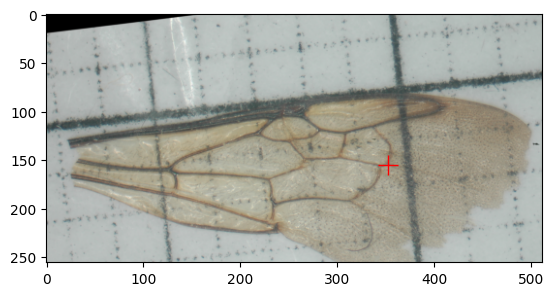

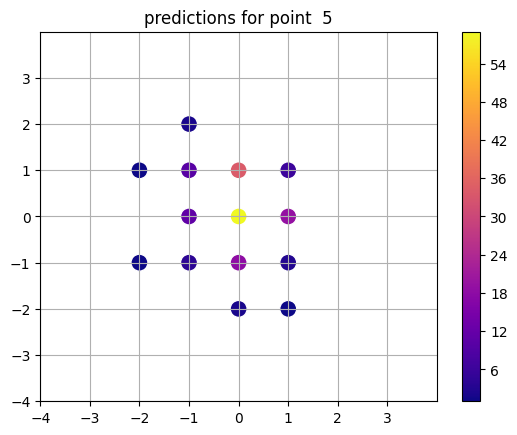

biais for point 5 : [-0.01169591  0.13450292]
mean error for point 5 : 0.7585219404800008
number of misclassified points for point 5 :  0
misclassification rate for point 5 : 0.0


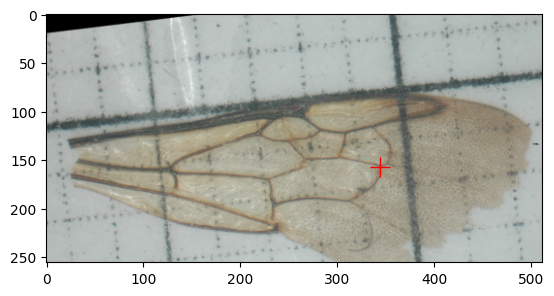

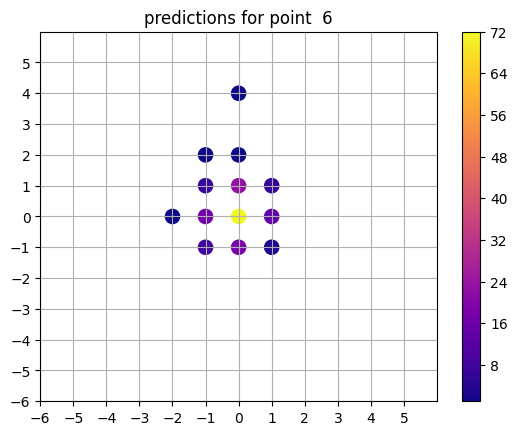

biais for point 6 : [-0.06432749  0.08187135]
mean error for point 6 : 0.6711285374975495
number of misclassified points for point 6 :  0
misclassification rate for point 6 : 0.0


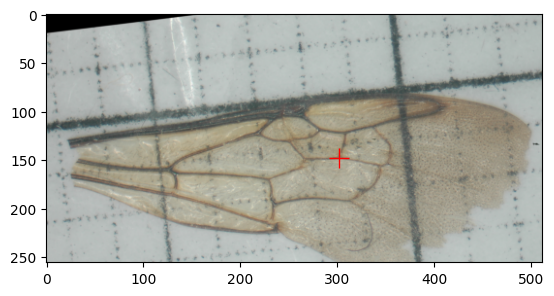

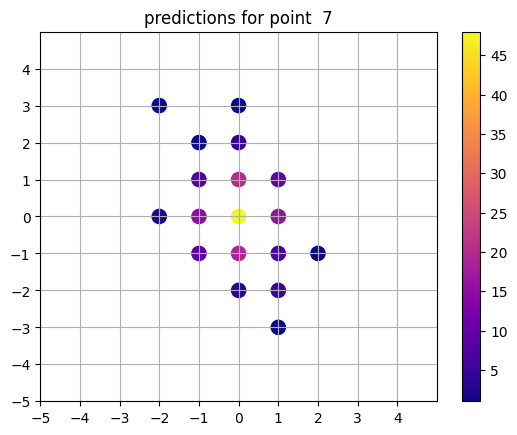

biais for point 7 : [ 0.01169591 -0.00584795]
mean error for point 7 : 0.9444652976538955
number of misclassified points for point 7 :  0
misclassification rate for point 7 : 0.0


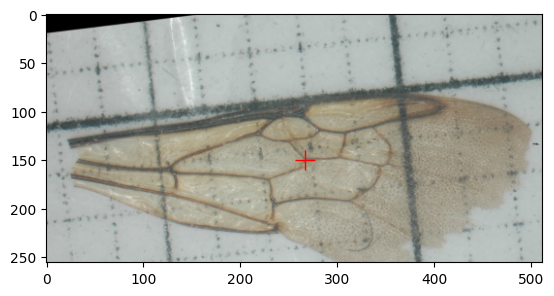

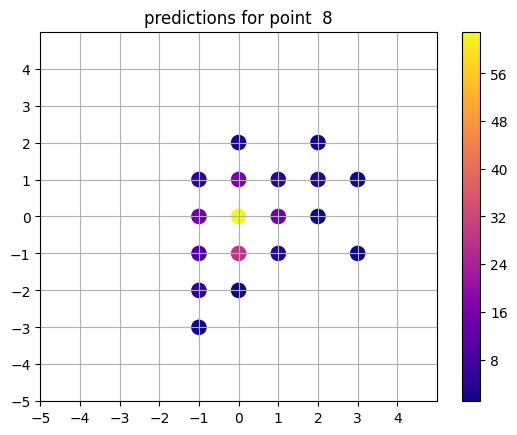

biais for point 8 : [ 0.02339181 -0.12865497]
mean error for point 8 : 0.80987178463574
number of misclassified points for point 8 :  0
misclassification rate for point 8 : 0.0


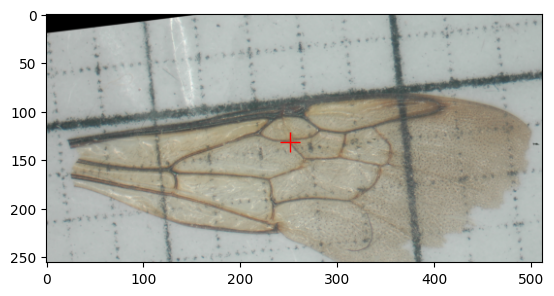

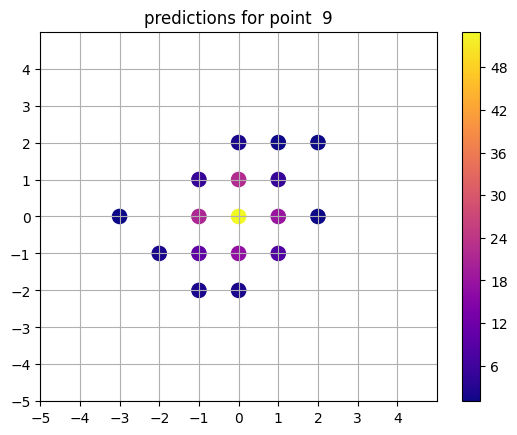

biais for point 9 : [-0.05263158 -0.02923977]
mean error for point 9 : 0.8456534898169111
number of misclassified points for point 9 :  0
misclassification rate for point 9 : 0.0


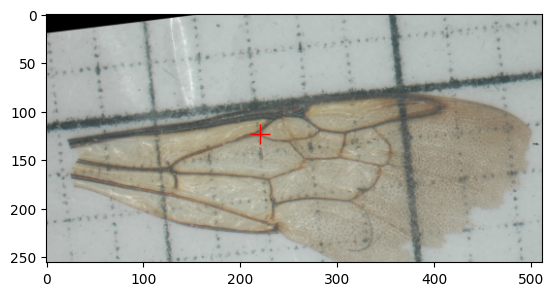

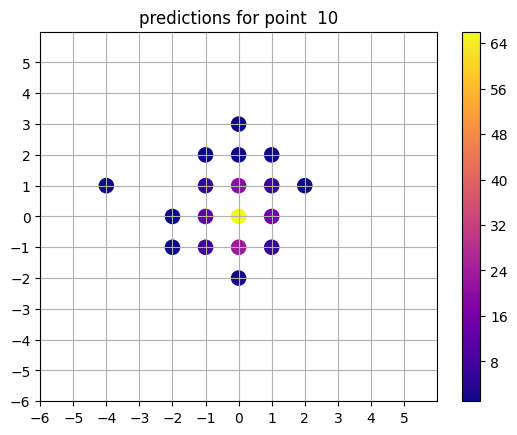

biais for point 10 : [-0.02339181  0.01169591]
mean error for point 10 : 0.7568579917832995
number of misclassified points for point 10 :  0
misclassification rate for point 10 : 0.0


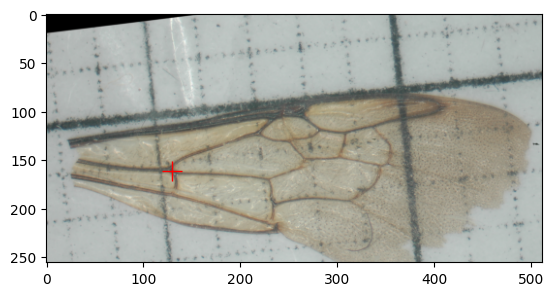

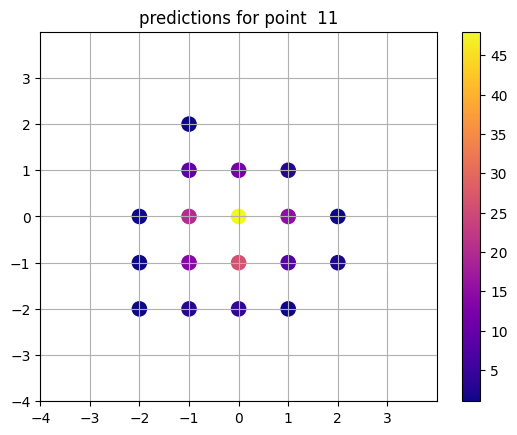

biais for point 11 : [-0.11764706 -0.25294118]
mean error for point 11 : 0.9047072474437045
number of misclassified points for point 11 :  1
misclassification rate for point 11 : 0.005847953216374269


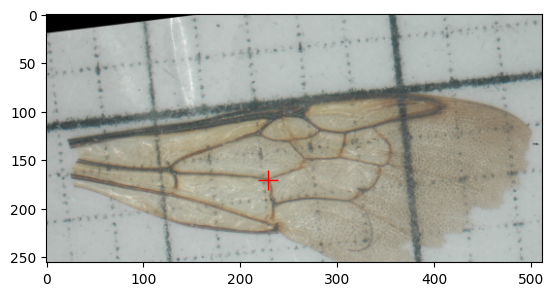

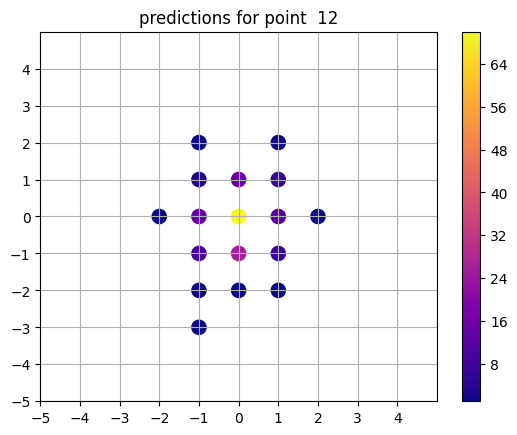

biais for point 12 : [-0.00584795 -0.12865497]
mean error for point 12 : 0.7127257438120935
number of misclassified points for point 12 :  0
misclassification rate for point 12 : 0.0


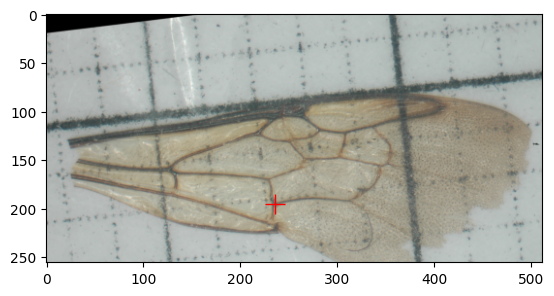

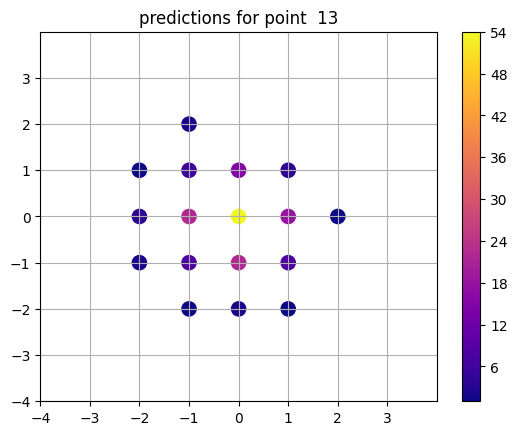

biais for point 13 : [-0.11695906 -0.10526316]
mean error for point 13 : 0.8387253126561347
number of misclassified points for point 13 :  0
misclassification rate for point 13 : 0.0


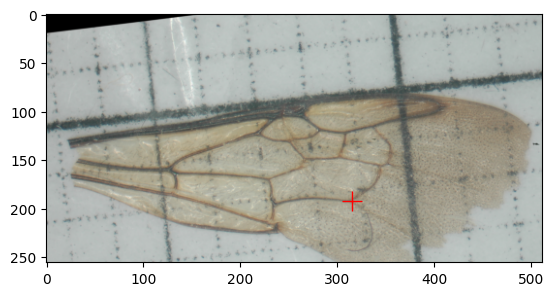

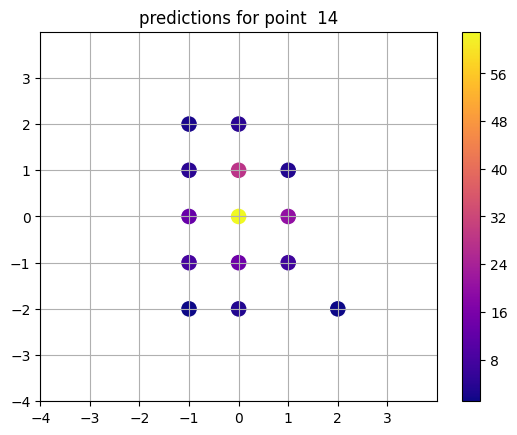

biais for point 14 : [0.02339181 0.04678363]
mean error for point 14 : 0.7581832130377406
number of misclassified points for point 14 :  0
misclassification rate for point 14 : 0.0


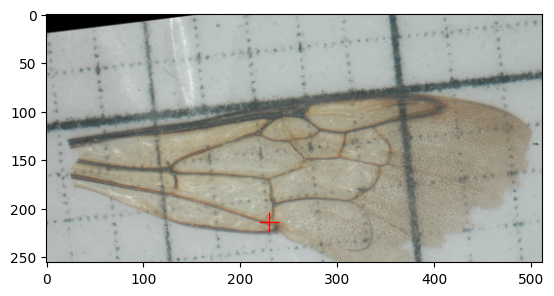

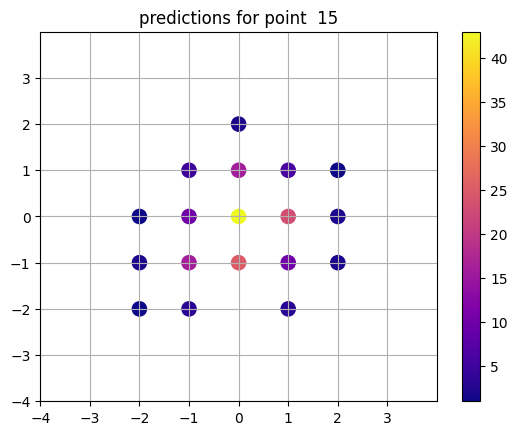

biais for point 15 : [ 0.05847953 -0.21637427]
mean error for point 15 : 0.9576086355850785
number of misclassified points for point 15 :  0
misclassification rate for point 15 : 0.0


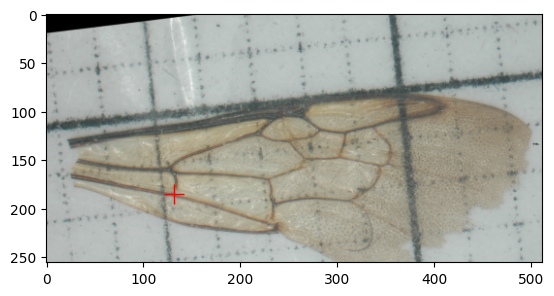

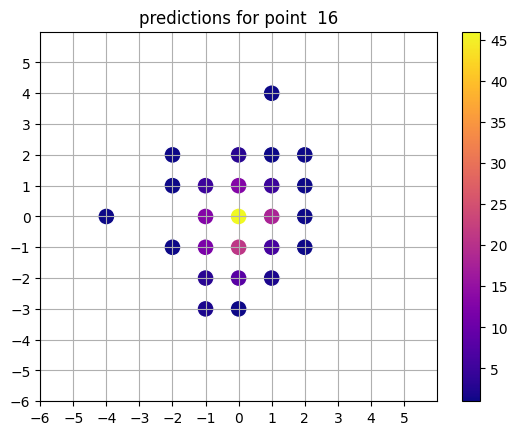

biais for point 16 : [-0.02380952 -0.20833333]
mean error for point 16 : 1.0360903256957819
number of misclassified points for point 16 :  3
misclassification rate for point 16 : 0.017543859649122806


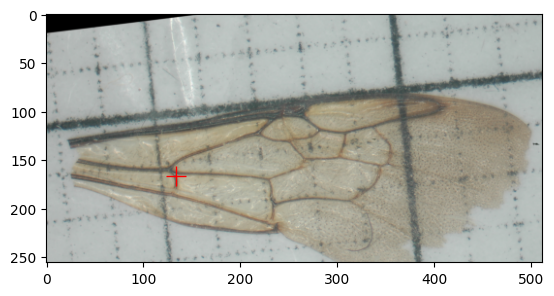

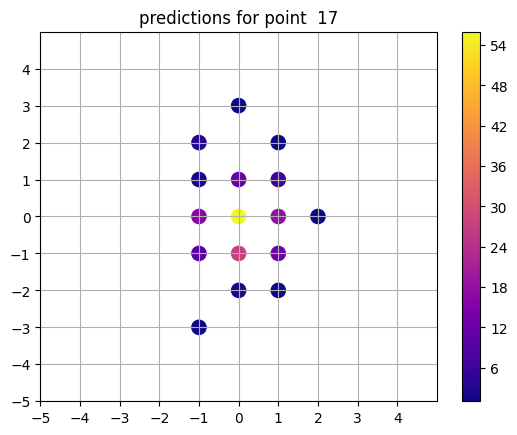

biais for point 17 : [ 0.05294118 -0.16470588]
mean error for point 17 : 0.8246072822425486
number of misclassified points for point 17 :  1
misclassification rate for point 17 : 0.005847953216374269
global mean biais : [-0.03328046 -0.04282977]
number of uncorrectly annotated wings : 7
fraction of uncorrectly annotated wings : 0.04093567251461988
.......
global mean error : 0.8512103395714833


In [14]:
#let's open and process annotations and predicted annotations for test set
#define functions to assign each prediction to a point

example_wing = val_set_noaug[0]

example_wing = np.transpose(example_wing,(1,2,0))



threshold  = 5 #if the distance to the annotation is higher than this threshold, then we classifie this point as wrongly classified, and don' t consider it for calculus
count_threshold = 1


for index,annotation in enumerate(original_annotations_list_t):
        predicted_annotation = predicted_annotations_list[index]
    
        plt.plot(predicted_annotation[:,1],predicted_annotation[:,0],'ro')
        plt.plot(annotation[:,1],annotation[:,0],'b+')
plt.show()

final_assignations = []
for index,annotation in enumerate(original_annotations_list_t):
    predicted_annotation = predicted_annotations_list[index]
    closest_neighboors = closest_neighboor(predicted_annotation,annotation)
    final_assignation = point_assignation_v2(predicted_annotation,annotation)
    final_assignations.append((final_assignation,annotation))


biais_list = []
mean_error_list = []
misclassification_rate_list = []
clean_mean_error_list = []
uncorrect_wings = [] #this will store indexes of wings uncorrectly classified


for index in range(len(original_annotations_list_t[0])):
    pos_count = {} 
    misclassifications = [] 

    for i,(final,annotate) in enumerate(final_assignations):
        annotate_int = np.int64(annotate) #converting float coordinates to int coordinates
        annotate_tuple = from_array_to_tuple_2D(annotate_int)



        for ann,pred in final:
            ann = tuple(np.int64(np.array(ann))) #converting coordinates to integer the same way as above
            current_index = annotate_tuple.index(ann)
            relative_pos = np.array(pred)-np.array(ann) #+ np.array([1,0]) #this correction is necessary because the creation_relief function don't place the maximax at the right places
            relative_pos = tuple(relative_pos)
            if current_index == index:# or current_index == 11 or current_index == 17:
                dist = np.linalg.norm(np.array(ann)-np.array(pred))
                if dist < threshold:
                    # plt.plot(ann[1],ann[0],'b+')
                    # plt.plot(pred[1],pred[0],'ro')
                    if relative_pos in pos_count.keys():
                        pos_count[relative_pos] += 1
                    else : pos_count[relative_pos] = 1
                    #plt.plot(relative_pos[1],relative_pos[0],'ro')
                else :
                    misclassifications.append(relative_pos)
                    uncorrect_wings.append(i)


    #let's display a wing from test set with the annotated point index (to show which one it is)
 
    plt.imshow(example_wing)
    x_i,y_i = original_annotations_list_t[0][index]
    plt.plot(y_i,x_i,'r+',markersize = 15)
    plt.show()

    positions = list(pos_count.keys())
    populations = np.array(list(pos_count.values()))
    population_clean = [pop  for pop in populations if pop >= count_threshold ]
    population_clean_index = [i for i in range(len(populations)) if populations[i] >= count_threshold]
    positions_clean = [positions[i] for i in population_clean_index]
    misclassification_rate = len(misclassifications)/len(original_annotations_list_t)

    X = np.array([x for x,y in positions_clean])
    Y = np.array([y for x,y in positions_clean])

    plt.scatter(X, Y, c=population_clean, cmap='plasma', edgecolors='w',s=150)
    plt.title(f"predictions for point  {index}")
    
    # Adding the color bar
    cb = plt.colorbar()

    # Setting the color bar to have only integer ticks
    cb.locator = plt.MaxNLocator(integer=True)
    cb.update_ticks()

    # Setting axis limits symmetrically around zero
    max_limit = max(np.max(np.abs(X)), np.max(np.abs(Y)))
    plt.xlim(-max_limit-2, max_limit+2)
    plt.ylim(-max_limit-2, max_limit+2)

    # Setting integer ticks
    plt.xticks(np.arange(-int(max_limit)-2, int(max_limit) + 2, 1))
    plt.yticks(np.arange(-int(max_limit)-2, int(max_limit) + 2, 1))


    biais = calculate_biais(pos_count)
    biais_list.append(biais)
    plt.grid()

    plt.show()
    print(f"biais for point {index} :", biais)

    #let's calculate some useful metrics

    #mean distance
    mean_error = calculate_mean_error(pos_count)
    mean_error_list.append(mean_error)
    misclassification_rate_list.append(misclassification_rate)
    print(f"mean error for point {index} :", mean_error)
    print(f"number of misclassified points for point {index} : ",len(misclassifications))
    print(f"misclassification rate for point {index} :",misclassification_rate)

#let's have a look on biais
biais_list = np.array(biais_list)
mean_biais = np.mean(biais_list,axis = 0)
print("global mean biais :",mean_biais) 

#let's have a look of correcly annotated wings rate
uncorrect_wings = list(set(uncorrect_wings))
print("number of uncorrectly annotated wings :",len(uncorrect_wings))
print("fraction of uncorrectly annotated wings :",len(uncorrect_wings)/len(final_assignations))
print(".......")
print("global mean error :",np.mean(np.array(mean_error_list)))


In [11]:
import json

In [12]:
#saving all performances metrics into a json file

performances_dir = '/home/gabriel/Documents/TR DIMA/data_clean/performances'
N_pt = 18
performances_dict = {}

for i in range(N_pt):
    current_biais = biais_list[i]
    current_m_err = mean_error_list[i]
    current_mis_r = misclassification_rate_list[i]
    performances_dict[i] = (current_biais[0],current_biais[1],current_m_err,current_mis_r)

global_biais = mean_biais
m_err = np.mean(np.array(mean_error_list))
mis_r = len(uncorrect_wings)/len(final_assignations)
performances_dict['all'] = (global_biais[0],global_biais[1],m_err,mis_r)

In [13]:
print(performances_dict)
with open(performances_dir + '/' + model_name + ".json",'w') as file:
    json.dump(performances_dict,file)

{0: (np.float64(-0.09467455621301775), np.float64(0.07100591715976332), np.float64(1.2019645343207808), 0.011695906432748537), 1: (np.float64(-0.04678362573099415), np.float64(0.16374269005847952), np.float64(1.133303121423839), 0.0), 2: (np.float64(-0.029239766081871343), np.float64(-0.03508771929824561), np.float64(0.7082357892702588), 0.0), 3: (np.float64(-0.07017543859649122), np.float64(-0.07602339181286549), np.float64(0.7062549668460765), 0.0), 4: (np.float64(-0.11176470588235295), np.float64(0.07058823529411765), np.float64(0.7528808980852667), 0.005847953216374269), 5: (np.float64(-0.011695906432748537), np.float64(0.13450292397660818), np.float64(0.7585219404800008), 0.0), 6: (np.float64(-0.06432748538011696), np.float64(0.08187134502923976), np.float64(0.6711285374975495), 0.0), 7: (np.float64(0.011695906432748537), np.float64(-0.005847953216374269), np.float64(0.9444652976538955), 0.0), 8: (np.float64(0.023391812865497075), np.float64(-0.1286549707602339), np.float64(0.8098